## Homework

In [2]:
import math
from ROOT import *
import numpy as np

# For inline image display
from IPython.display import Image

ModuleNotFoundError: No module named 'ROOT'

In [29]:
# Set ROOT graphics options

gROOT.SetStyle("Plain")

# Default canvas  size

gStyle.SetCanvasDefW(600)
gStyle.SetCanvasDefH(400)
 
# set the margins
  
gStyle.SetPadBottomMargin(0.18)
gStyle.SetPadTopMargin(0.08)
gStyle.SetPadRightMargin(0.08)
gStyle.SetPadLeftMargin(0.17)

# set the number of divisions to show

gStyle.SetNdivisions(510, "xy")

# show grid

gStyle.SetPadGridX(1)
gStyle.SetPadGridY(1)

# border ploted only around statistics

gStyle.SetPadBorderMode(0)
gStyle.SetFrameBorderMode(0)
gStyle.SetLegendBorderSize(0)
gStyle.SetTitleBorderSize(0)
gStyle.SetStatBorderSize(1)

# Text sizes

gStyle.SetTextSize(0.05)
gStyle.SetTitleSize(0.06,"xyz")
gStyle.SetLabelSize(0.05,"xyz")

gStyle.SetLabelOffset(0.015,"xyz")
gStyle.SetTitleOffset(1.2,"yz")
gStyle.SetTitleOffset(1.0,"x")

# Font settings

font = 42
gStyle.SetTitleFont(font)
gStyle.SetTitleFontSize(0.05)
gStyle.SetStatFont(font)
gStyle.SetStatFontSize(0.06)
gStyle.SetTextFont(font)
gStyle.SetLabelFont(font,"xyz")
gStyle.SetTitleFont(font,"xyz")
gStyle.SetLegendFont(font)

# Line settings

gStyle.SetHistLineWidth(2)
gStyle.SetFrameLineWidth(2)
gStyle.SetFuncWidth(2)
gStyle.SetHistLineColor(kBlue)
gStyle.SetFuncColor(kRed)

# Log scale
gStyle.SetOptLogy(0)    # 0 no log y scale, 1 log y scale

# Histogram title
gStyle.SetOptTitle(1)  

# Histogram statistics
gStyle.SetOptStat(1100)

# Fit results
gStyle.SetOptFit(0) 


In [30]:
# Class for single shower particle

class shParticle:
    'Particle of the EM shower (in 1D)'
    E = 0.0     # initial energy
    q = 0       # charge
    xmin = 0.0
    xmax = 0.0
    
    def __init__(self,E,q,xmin):
        self.E = E
        self.q = q
        self.xmin = xmin
        self.xmax = xmin
        
    def __str__(self):
        if self.xmin == self.xmax :
            return 'E = %g   q = % g    created at X = %g [X0]' % (self.E, self.q, self.xmin)
        else :
            return 'E = %g   q = % g    propagated from X = %g to %g  [X0]' % (self.E, self.q, self.xmin, self.xmax)
        
    def setlen(self,shlen):     # define endpoint of the particle; length after it decays
        self.xmax = self.xmin + shlen
 
    def getlen(self):       # define start of the particle
        return self.xmax - self.xmin
    
    def getsamp(self,dX):   # tells how long the track of the particle is in quantized manner
        i1 = int(self.xmin/dX)
        i2 = int(self.xmax/dX)
        return i2-i1


In [31]:
# EM shower class

class emShower:
    'Model of EM shower development'

    def __init__(self,E0,q0,x0):
        # initialize with input particle
        self.shower = []    # collection of particles
        self.shower.append(shParticle(E0,q0,x0))
        # only propagated particles are counted
        # so set counters to zero at that point
        self.npar = 0  
        self.nch = 0    # number of charged particles
        self.chlen = 0.0
        self.eloss = 0.0

    def __str__(self):
        return 'Shower with %d particles, %d charged, total track lenght %g X0, energy loss %g GeV' % (self.npar, self.nch, self.chlen, self.eloss)
    
    def develope(self,Ec,dEdx=0.0):
        # consider increasing number of particles in the shower
        for par in self.shower :
            # conversion/radiation length [X0]
            if par.q == 0 :     # check if it is charged
                intlen = 9.0/7.0
            else :  
                intlen = 1.0    # electron positron
               
            # generate conversion/radiation point
            
            shlen = np.random.exponential(intlen)
            
            # check energy loss of particle
            
            elen = 0
            
            if par.q != 0 and dEdx > 0 :
                elen = shlen * dEdx
                if elen > par.E :
                    shlen = par.E/dEdx
                    elen = par.E
            
            # propagate particle to this point
            
            par.setlen(shlen)
            self.npar+=1
            if par.q != 0 :
                self.nch+=1
                self.chlen+=shlen
                self.eloss+=elen

            # Energy at the final point
            
            Eleft = par.E - elen
            
            # Final point - origin for new particles
            
            xnew = par.xmax 
           
            # If above critical energy:
            #   convert gamma to two photons or radiate photon
            if Eleft > Ec :
                E1 = Eleft * np.random.random(1)    #  Very siplified energy splitting
                E2 = Eleft - E1
                if par.q == 0 :     # if it is photons
                    self.shower.append(shParticle(E1,+1,xnew))
                    self.shower.append(shParticle(E2,-1,xnew))
                else:       # electron positron
                    self.shower.append(shParticle(E1,par.q,xnew))
                    self.shower.append(shParticle(E2,0,xnew))
                    
    def sample(self,Xsamp):     # calculate how many samples are from the shower
        nsamp = 0
        for par in self.shower:
            if par.q != 0 :
                nsamp += par.getsamp(Xsamp)
        return nsamp

    def profile(self,Nbin,Xmax):        # shape of the shower as the histogram
        hprof = TH1D("hprof","Shower profile",Nbin, 0, Xmax)
        hprof.GetXaxis().SetTitle("x [X0]")
        hprof.GetYaxis().SetTitle("Particles")
        dX=Xmax/Nbin
        for par in self.shower:
            if par.q != 0 :
                nx = par.getsamp(dX)
                for ix in range(nx):
                    hprof.Fill(par.xmin+ix*dX)
        return hprof
    
    def dump(self,Nprt):
        for iprt in range(Nprt):
            print(self.shower[iprt])
            

## Our shower simulation

In [32]:
#  Incident particle

E0 = 1.
q0 = -1

# Initialise shower with incident particle

myshower = emShower(E0,q0,0.)

print(myshower.shower[0])

# Critical energy [GeV] for Copper

Ec = 0.020

# Ionization losses [GeV/X0] for Copper (MIP)

dEdx = 0.018

# Execute shower development procedure

myshower.develope(Ec,dEdx)

# Test shower dump (first 10 rows)

myshower.dump(10)      # create particles in shower
print(myshower)         # summary

# Other useful  information about our shower
# Direct access to shower information
# Can be used to model response of the uniform calorimeter

print('Shower with ',myshower.npar,' particles, ',myshower.nch,' charged particles')
print('Total length of charged particle tracks: ',myshower.chlen)

E = 1   q = -1    created at X = 0 [X0]
E = 1   q = -1    propagated from X = 0 to 2.34804  [X0]
E = 0.610958   q = -1    propagated from X = 2.34804 to 3.34968  [X0]
E = 0.346778   q =  0    propagated from X = 2.34804 to 2.95116  [X0]
E = 0.00496546   q = -1    propagated from X = 3.34968 to 3.62554  [X0]
E = 0.587963   q =  0    propagated from X = 3.34968 to 4.76111  [X0]
E = 0.081332   q =  1    propagated from X = 2.95116 to 3.23606  [X0]
E = 0.265446   q = -1    propagated from X = 2.95116 to 6.58098  [X0]
E = 0.0677186   q =  1    propagated from X = 4.76111 to 5.25454  [X0]
E = 0.520244   q = -1    propagated from X = 4.76111 to 7.52235  [X0]
E = 0.00364427   q =  1    propagated from X = 3.23606 to 3.27795  [X0]
Shower with 87 particles, 62 charged, total track lenght 43.5158 X0, energy loss 0.783285 GeV
Shower with  87  particles,  62  charged particles
Total length of charged particle tracks:  [43.51583346]


#### Fitting function

In [33]:
def fitfunc(x0, y0, sigma, x):
    return y0 * np.exp(- (x0 / sigma) ** 2 * ((x - x0) / x0) - np.log(x / x0))

##### Test fitfunc

In [34]:
a = fitfunc(1, 2, 3, 4)
a

0.3582656552868947

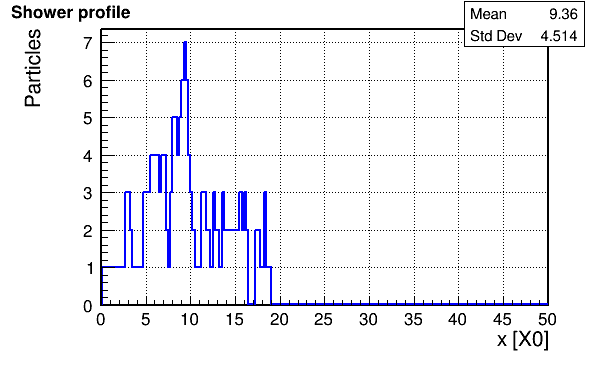

Warning in <TROOT::Append>: Replacing existing TH1: hprof (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: csh
Info in <TCanvas::Print>: png file shprofile.png has been created


In [35]:
# Histogram of the longitudinal shower profile

Xmax = 50.
Nprof = 200

shprofile=myshower.profile(Nprof,Xmax)

# res = shprofile.Fit(fitfunc, "s")

csh = TCanvas('csh')

shprofile.DrawCopy()

csh.Update()
csh.Print('shprofile.png')

Image(filename='shprofile.png')

In [36]:
# Repeat shower simulation multiple times

avprofile=shprofile
avprofile.SetNameTitle("havprof","Average shower profile")
avprofile.Reset()

Nmc = 1000
myshowers = []

for imc in range(Nmc):
    newshower = emShower(E0,q0,0.)
    newshower.develope(Ec,dEdx)
    myshowers.append(newshower)
    if (imc+1)%100 == 0:
        print(imc+1,' showers generated ',myshowers[imc].npar,' particles')

100  showers generated  91  particles
200  showers generated  81  particles
300  showers generated  79  particles
400  showers generated  77  particles
500  showers generated  85  particles
600  showers generated  99  particles
700  showers generated  89  particles
800  showers generated  85  particles
900  showers generated  69  particles
1000  showers generated  91  particles


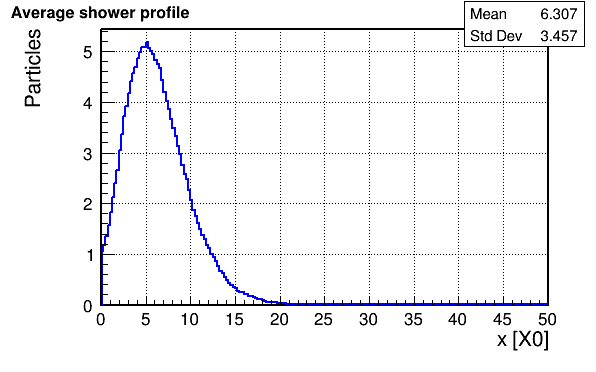

Warning in <TCanvas::Constructor>: Deleting canvas with same name: csh2
Info in <TCanvas::Print>: png file avprofile.png has been created


In [37]:
# Average generated showers

wmc = 1/Nmc

for newshower in myshowers:
    newprofile=newshower.profile(Nprof,Xmax)
#    newprofile=myshowers[imc].profile(Nprof,Xmax)
    avprofile.Add(newprofile,wmc)
    newprofile.Delete()

csh2 = TCanvas('csh2')

avprofile.DrawCopy()
# avprofile.Fit(fitfunc)

csh2.Update()
csh2.Print('avprofile.png')

Image(filename='avprofile.png')

In [1]:
def fitfunc(x0, y0, sigma, x):
    return y0 * np.exp(- (x0 / sigma) ** 2 * ((x - x0) / x0) - np.log(x / x0))

class myfunc:   # fit function as a class
    def __call__( self, t, par ):
        x0 = par[0] # x center
        y0 = par[1] #y center
        sigma = par[2] #sigma
        x = t[0]   
        tmp = y0 * np.exp(- (x0 / sigma) ** 2 * ((x - x0) / x0) - np.log(x / x0))
        return tmp

fitrangestart = 0   
fitrangeend = Xmax

parN = 3    # number of fit parameters 

func = TF1("myfunction", myfunc(), fitrangestart, fitrangeend, parN)    # initialization of fitting function
func.SetParameters(5, 5, 3)     # setting parameters for our function

avprofile.Fit(func)

csh2.Update()
csh2.Print('avprofile.png')

Image(filename='avprofile.png')



NameError: name 'Xmax' is not defined